In [1]:
import os
import glob
import threading
import numpy as np
from PIL import Image

base_path = '/atlas/home/zwpeng/datadreams/data/'
test_path = 'test/'
mask_path = 'mask_new/'
test_set = glob.glob(os.path.join(base_path,test_path,'*.tiff'))
mask_set = glob.glob(os.path.join(base_path,mask_path,'*.jpg'))
# print(test_set,len(mask_set))

In [2]:
from keras.models import load_model

model = load_model('model10032100_05_p.h5')

Using TensorFlow backend.


In [3]:
def prediction_from_model(patch, model):
    prediction = model.predict(patch.reshape(1, 139, 139, 3))
    return prediction

In [4]:
from tqdm import tqdm

widths, heights = 139,139
step_len = 32

img = Image.open(test_set[1])
src_mask = Image.open(os.path.join(base_path, mask_path, os.path.splitext(test_set[1])[0].split('/')[-1] + '.png.jpg'))
pre_map = np.zeros(img.size)
y, pred = [],[]
for h in tqdm(range(img.size[0]//step_len)):
    for w in range(img.size[1]//step_len):
        mask_pat = src_mask.crop((w*step_len,  h*step_len, w*step_len+widths, h*step_len+heights))
        mask_pat_array = np.array(mask_pat.convert("L"))
        if mask_pat_array.any():
            y.append(1)
        else:
            y.append(0)
        pat = img.crop((w*step_len,  h*step_len, w*step_len+widths, h*step_len+heights))
        pat_array = np.array(pat.convert("RGB"))/255.
        pre_pat = prediction_from_model(pat_array, model)
        pred.append(pre_pat[0][0])
        pre_map[w*step_len:(w+1)*step_len,h*step_len:(h+1)*step_len] = pre_pat[0][0]

100%|██████████| 64/64 [02:52<00:00,  2.72s/it]


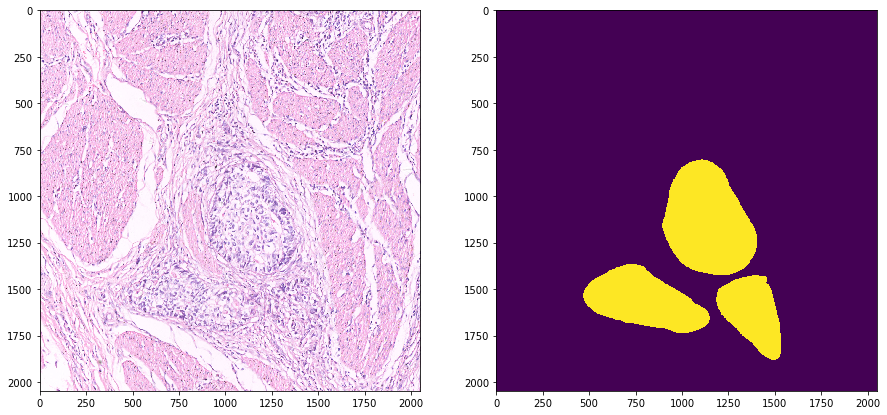

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(1,2,figsize=(15,15))
ax = axes.flatten()
ax[0].imshow(img)
ax[1].imshow(src_mask)

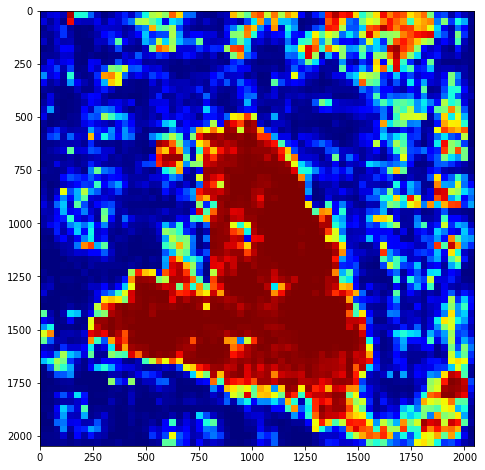

In [6]:
fig1, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.transpose(pre_map), cmap='jet', vmin=0, vmax=1)
# ax.imshow(pre_map, cmap='jet', vmin=0, vmax=1)
# fig1.savefig(model_path+'/'+'pre'+(test_set[i].split('.')[0]).split('/')[-1]+'.png')
fig1.savefig('w02.png')
# plt.close()

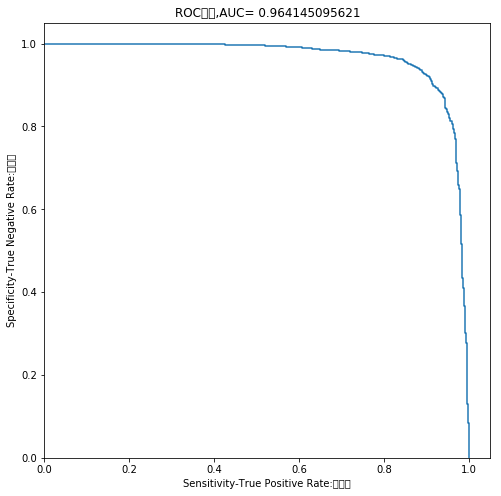

In [7]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=None)
fig2, ax = plt.subplots(figsize=(8, 8))
ax.plot(tpr, [(1-fpr[i]) for i in range(fpr.shape[0])])    # 一句循环获取该array
ax.set_xlim([0.0,1.05])
ax.set_ylim([0.0,1.05])
ax.set_xlabel('Sensitivity-True Positive Rate:正确率')
ax.set_ylabel('Specificity-True Negative Rate:误判率')
ax.set_title('ROC曲线,AUC= %s'%(metrics.auc(fpr, tpr)))
fig2.savefig('w02_auc.png')
# plt.close()

In [10]:
model.save_weights('weights10032100_05_p.h5py')


# 引入权重，改变预测尺寸


In [1]:
import os
import glob
import threading
import numpy as np
from PIL import Image

base_path = '/atlas/home/zwpeng/datadreams/data/'
test_path = 'test/'
mask_path = 'mask_new/'
test_set = glob.glob(os.path.join(base_path,test_path,'*.tiff'))
mask_set = glob.glob(os.path.join(base_path,mask_path,'*.jpg'))
# print(test_set,len(mask_set))

In [10]:
def prediction_from_model(patch, model):
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    return prediction

In [6]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, Lambda, Dropout, GlobalAveragePooling2D, BatchNormalization

def get_trained_model(widths=256, heights=256):
    """ Returns a model with loaded weights. """
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(widths, heights, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    def load_keras_weights():
        """ Load a Keras checkpoint. """
        model.load_weights('weights10032100_05_p.h5py')

    load_keras_weights()

    return model

In [7]:
model = get_trained_model(widths=256, heights=256)

In [11]:
from tqdm import tqdm

widths, heights = 256, 256
step_len = 32

img = Image.open(test_set[1])
src_mask = Image.open(os.path.join(base_path, mask_path, os.path.splitext(test_set[1])[0].split('/')[-1] + '.png.jpg'))
pre_map = np.zeros(img.size)
y, pred = [],[]
for h in tqdm(range(img.size[0]//step_len)):
    for w in range(img.size[1]//step_len):
        mask_pat = src_mask.crop((w*step_len,  h*step_len, w*step_len+widths, h*step_len+heights))
        mask_pat_array = np.array(mask_pat.convert("L"))
        if mask_pat_array.any():
            y.append(1)
        else:
            y.append(0)
        pat = img.crop((w*step_len,  h*step_len, w*step_len+widths, h*step_len+heights))
        pat_array = np.array(pat.convert("RGB"))/255.
        pre_pat = prediction_from_model(pat_array, model)
        pred.append(pre_pat[0][0])
        pre_map[w*step_len:(w+1)*step_len,h*step_len:(h+1)*step_len] = pre_pat[0][0]

100%|██████████| 64/64 [02:48<00:00,  2.62s/it]


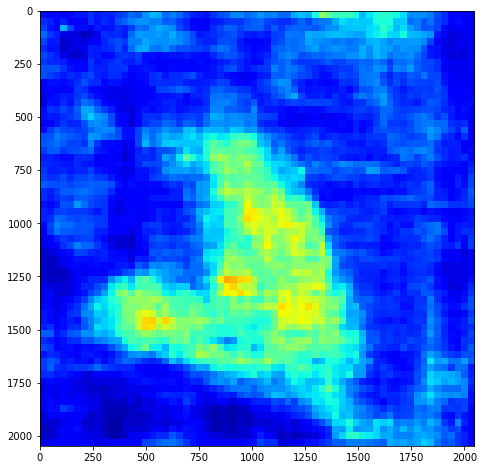

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.transpose(pre_map), cmap='jet', vmin=0, vmax=1)
# ax.imshow(pre_map, cmap='jet', vmin=0, vmax=1)
# fig1.savefig(model_path+'/'+'pre'+(test_set[i].split('.')[0]).split('/')[-1]+'.png')
fig1.savefig('w02.png')
# plt.close()